In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns
import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector
import scipy.stats as stats

from data_loader import (
    get_users_df,
    get_reviews_df,
    get_beers_df,
    get_breweries_df,
    join_breweries_on_beers,
    merge_reviews,
)

In [23]:
reviews_path_ba = "data/matched_beer_data/ratings_ba.txt"
reviews_path_rb = "data/matched_beer_data/ratings_rb.txt"
users_path_ba = "data/users_ba.csv"
users_path_rb = "data/users_rb.csv"
breweries_path = "data/matched_beer_data/breweries.csv"
beers_path = "data/matched_beer_data/beers.csv"

In [24]:
states_climate = pd.read_csv("data/states_climate.csv")
states_climate.set_index("State", inplace=True)

In [25]:
# Load the data

users_df_ba = get_users_df(users_path_ba)
users_df_rb = get_users_df(users_path_rb)
ba_df = get_reviews_df(reviews_path_ba)
rb_df = get_reviews_df(reviews_path_rb)
breweries_df = get_breweries_df(breweries_path)
beers_df = get_beers_df(beers_path)
beers_df = join_breweries_on_beers(beers_df, breweries_df)
reviews_df = merge_reviews(ba_df, rb_df, beers_df, users_df_ba, users_df_rb)

In [26]:
# Focus on the US only

pd.set_option("display.max_columns", None)

world_ratings = reviews_df.copy()
world_ratings["nbr_ratings"] = world_ratings["nbr_ratings_rb"] + world_ratings["nbr_ratings_ba"]

#drop rows where user_location is NaN   
world_ratings = world_ratings.dropna()

#create df with only users from the us
us_users_ratings = world_ratings[world_ratings["user_location"].str.contains("United States")]
us_users_ratings = us_users_ratings.T.drop_duplicates().T

#convert ratings from string to float
columns_compare = ["aroma", "appearance", "palate", "taste", "overall", "rating"]
us_users_ratings[columns_compare] = us_users_ratings[columns_compare].astype(float)

us_users_ratings["user_location"] = [name.replace("United States, ", "") for name in us_users_ratings["user_location"]]

#add climate column where climate is the climate of the state the user is from
us_users_ratings["climate"] = us_users_ratings["user_location"].map(states_climate["Climate"])

## 1. How does the climate of a user impact their preference in beer style?

1. What type of beer do users from each climate prefer? Is there significance?
2. What is the most rated beer from each climate? Is it one they dislike or like strongly?
3. Is the alcohol percentage of the preferred beer significant to the respective climates?

First, we will need to preprocess the `us_users_ratings` dataset to add a `general_style` column that is made from the beer's `style` which can be very specific. Then, we need to group the beers by climate to do the analysis to find answers to our questions.  

In [27]:
us_users_ratings.head()

,beer_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,abv,beer_avg_rating_ba,beer_name,brewery_id_ba,nbr_ratings_ba,beer_avg_rating_rb,beer_id_rb,brewery_id_rb,nbr_ratings_rb,beer_avg_rating_ba_rb,brewery_location,brewery_name,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings,nbr_ratings,climate
7,19827,English Pale Ale,1360753200,brewdude1982,brewdude1982.691169,4.25,4.50,3.25,3.75,3.75,3.91,This was a 12 oz bottle poured into a snifter....,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,North Carolina,264.0,164,Cfa
8,19827,English Pale Ale,1357729200,AgentMunky,agentmunky.409755,4.00,3.75,3.50,3.50,3.75,3.64,Poured from a 12 ounce bottle into a pilsner g...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,New York,2314.0,164,Cfa
12,19827,English Pale Ale,1353150000,ferrari29,ferrari29.320392,3.00,3.50,2.50,2.50,2.50,2.77,Beer poured from bottle into a Nonic shaped pi...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,Illinois,585.0,164,Dfa
14,19827,English Pale Ale,1342260000,OtherShoe2,othershoe2.233642,4.00,3.50,4.00,3.50,4.00,3.68,Pours a rich brownish red with some chill haze...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,Massachusetts,1315.0,164,Dfa
16,19827,English Pale Ale,1335607200,brentk56,brentk56.6284,4.50,3.00,3.50,2.50,2.50,2.84,Appearance: These Strangford Lough beers pour ...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,North Carolina,6306.0,164,Cfa


As there are many different styles of beer, it seems too hard to automate the process of tokenisation. We chose to export the dataframe with the style of beer and manually assign each one to a more general style. The groupings were made based on this reference: https://hospitalityinsights.ehl.edu/beer-types. These are:
- Lager
- Pale Ale
- Blonde Ale
- Brown Ale
- IPA
- Wheatbeer
- Porter
- Stout
- Sour Ale
- Scottish Ale

In [28]:
# get all styles of beers to regroup them by general types 

beer_styles = us_users_ratings[['style']].copy()
beer_styles = beer_styles.drop_duplicates()
#beer_styles.to_excel(r'beer_style.xlsx', index=False)

print("There are {} different beer styles in the dataset".format(len(beer_styles)))
beer_styles.head()

There are 104 different beer styles in the dataset


,style
7,English Pale Ale
91,English Bitter
156,Hefeweizen
162,English Porter
187,Kölsch


In [29]:
# reimport edited file with the corresponding beer types
mapping_df = pd.DataFrame(pd.read_excel("beer_style_edited.xlsx")) 
print("There are {} different general beer types".format(len(set(mapping_df['general_style']))))

# extract all general beer types
general_beer_types = list(set(mapping_df['general_style']))
print(general_beer_types)

# add a column to the us_users_ratings dataframe with the corresponding general beer type
us_users_ratings = pd.merge(us_users_ratings, mapping_df, on='style', how='left')
us_users_ratings.head()

There are 10 different general beer types
['Brown Ale', 'Blonde Ale', 'Porter', 'Scottish Ale ', 'Stout', 'IPA', 'Lager', 'Sour Ale', 'Pale Ale', 'Wheat beer']


,beer_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,abv,beer_avg_rating_ba,beer_name,brewery_id_ba,nbr_ratings_ba,beer_avg_rating_rb,beer_id_rb,brewery_id_rb,nbr_ratings_rb,beer_avg_rating_ba_rb,brewery_location,brewery_name,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings,nbr_ratings,climate,general_style
0,19827,English Pale Ale,1360753200,brewdude1982,brewdude1982.691169,4.25,4.50,3.25,3.75,3.75,3.91,This was a 12 oz bottle poured into a snifter....,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,North Carolina,264.0,164,Cfa,Pale Ale
1,19827,English Pale Ale,1357729200,AgentMunky,agentmunky.409755,4.00,3.75,3.50,3.50,3.75,3.64,Poured from a 12 ounce bottle into a pilsner g...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,New York,2314.0,164,Cfa,Pale Ale
2,19827,English Pale Ale,1353150000,ferrari29,ferrari29.320392,3.00,3.50,2.50,2.50,2.50,2.77,Beer poured from bottle into a Nonic shaped pi...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,Illinois,585.0,164,Dfa,Pale Ale
3,19827,English Pale Ale,1342260000,OtherShoe2,othershoe2.233642,4.00,3.50,4.00,3.50,4.00,3.68,Pours a rich brownish red with some chill haze...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,Massachusetts,1315.0,164,Dfa,Pale Ale
4,19827,English Pale Ale,1335607200,brentk56,brentk56.6284,4.50,3.00,3.50,2.50,2.50,2.84,Appearance: These Strangford Lough beers pour ...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,North Carolina,6306.0,164,Cfa,Pale Ale


In [30]:
# group by the climates and aggregate the overall rating per type of beer

climate_beer_type = us_users_ratings.groupby(['climate', 'general_style'])['overall'].mean().reset_index()
print(climate_beer_type['climate'].unique())
print('There are {} different climates'.format(len(climate_beer_type['climate'].unique())))
climate_beer_type.head()

['Bsk' 'Cfa' 'Cfb' 'Csa' 'Csb' 'Dfa' 'Dfb' 'Dfc' 'Dsb' 'Dsc']
There are 10 different climates


,climate,general_style,overall
0,Bsk,Blonde Ale,3.791045
1,Bsk,Brown Ale,3.837165
2,Bsk,IPA,3.868174
3,Bsk,Lager,3.724619
4,Bsk,Pale Ale,3.749457


<Axes: xlabel='climate', ylabel='general_style'>

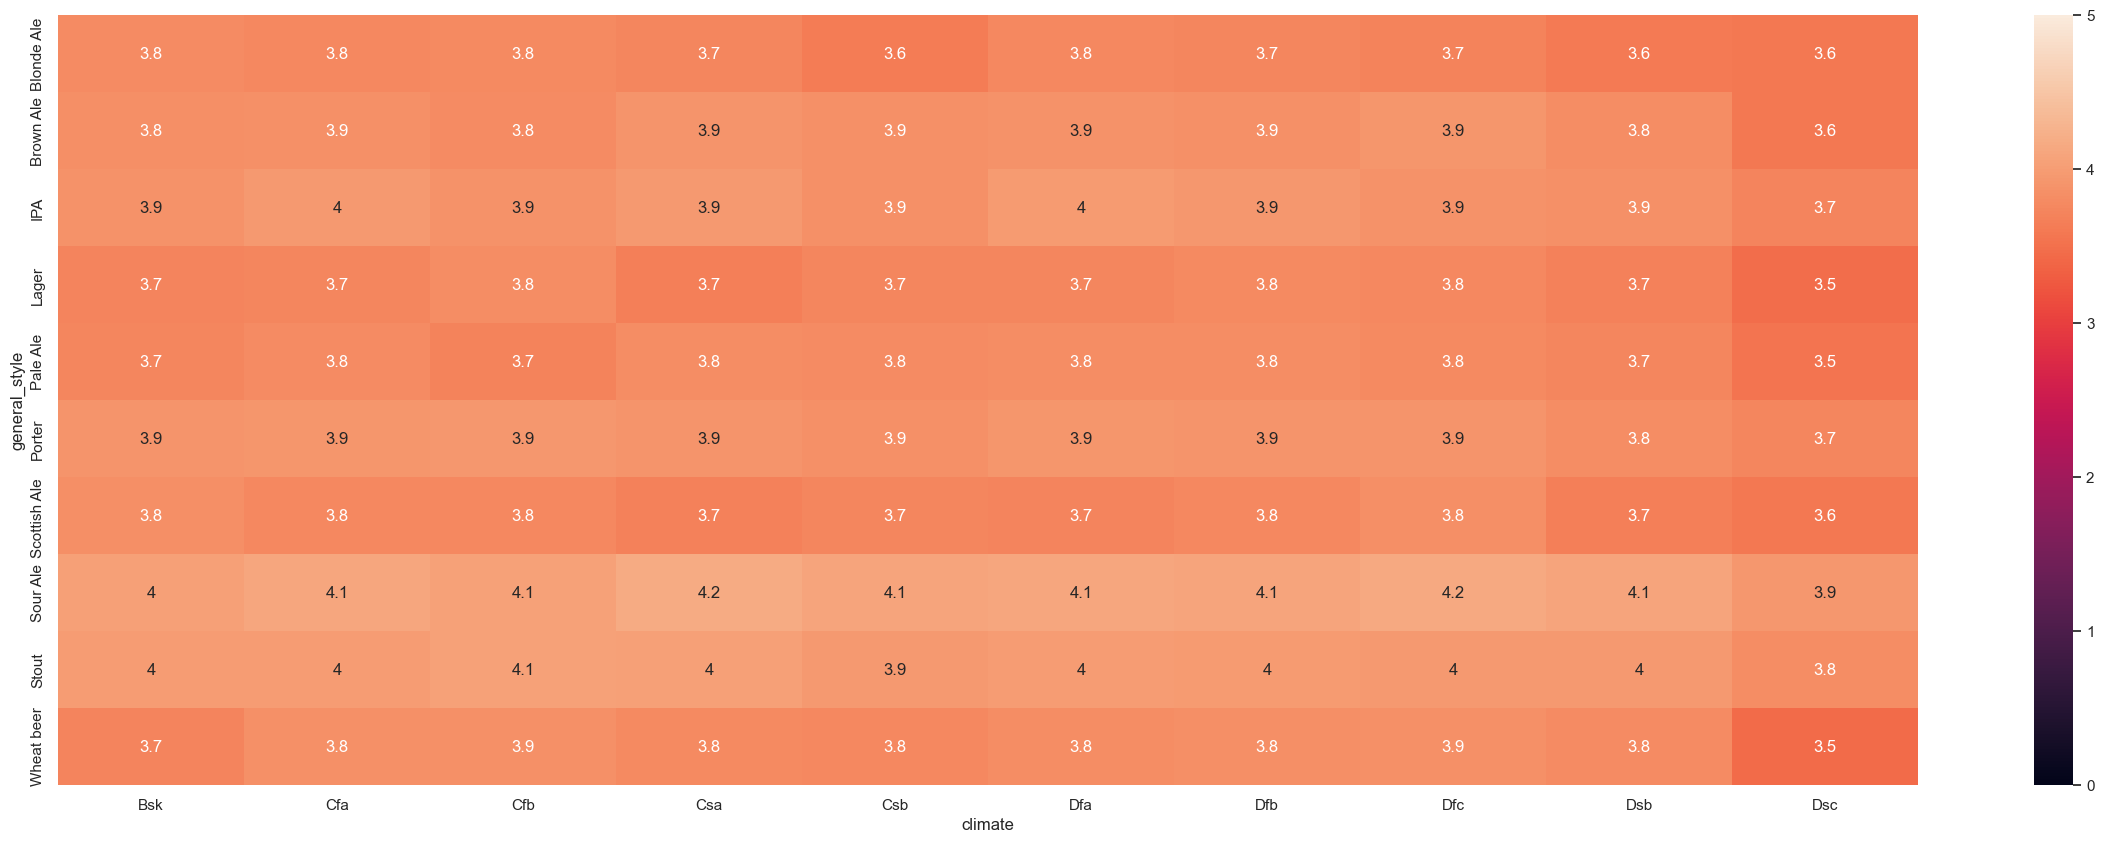

In [31]:
# heatmap of the ratings given to each beer type in each climate

df = pd.crosstab(climate_beer_type['general_style'],climate_beer_type['climate'],values=climate_beer_type['overall'],aggfunc='mean')
sns.heatmap(df, annot=True, vmin = 0, vmax = 5)

There doesn't seem to be a significant difference between the ratings between the climates. There do seem to be types of beers that are generally preffered than others. Let's try to analyse these results in a bit more detail to look for significant differences. For example, the Dsc climate seems to have the most variety in results so we can explore this one first.

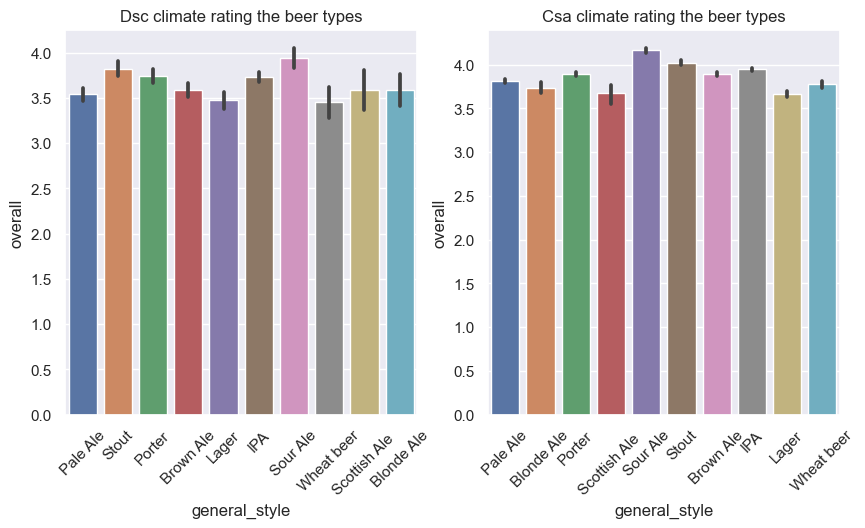

In [43]:
# view the average rating per beer type in Dsc and Csa

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,5))

plot_1 = sns.barplot(x='general_style', y='overall', data=us_users_ratings[us_users_ratings['climate']=='Dsc'], ax = ax0)
plot_1.set_xticklabels(plot_1.get_xticklabels(), rotation=45)
plot_1.set_title('Dsc climate rating the beer types')

plot_2 = sns.barplot(x='general_style', y='overall', data=us_users_ratings[us_users_ratings['climate']=='Csa'], ax = ax1)
plot_2.set_xticklabels(plot_2.get_xticklabels(), rotation=45)
plot_2.set_title('Csa climate rating the beer types')

plt.show()

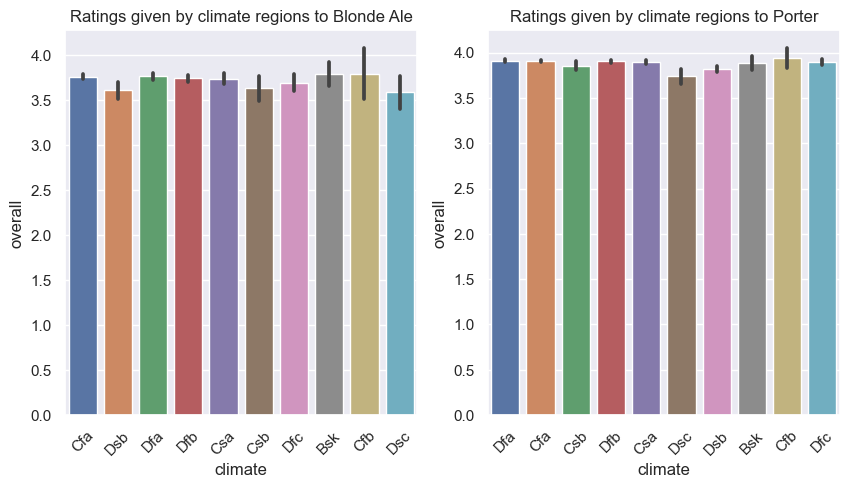

In [44]:
# view the ratings given to Blonde Ale and Porter in each climate

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,5))

plot_1 = sns.barplot(x='climate', y='overall', data=us_users_ratings[us_users_ratings['general_style']=='Blonde Ale'], ax = ax0)
plot_1.set_title('Ratings given by climate regions to Blonde Ale')
plot_1.set_xticklabels(plot_1.get_xticklabels(), rotation=45)

plot_2 = sns.barplot(x='climate', y='overall', data=us_users_ratings[us_users_ratings['general_style']=='Porter'], ax = ax1)
plot_2.set_title('Ratings given by climate regions to Porter')
plot_2.set_xticklabels(plot_2.get_xticklabels(), rotation=45)

plt.show()

We want to test if the difference in ratings between the different beer types in each climate is significant. We therefore perform a t-test between each climate and beer type to see if their rating is sginificantly different. Our null hypothesis is: the mean rating given by users of a climate to a certain beer is similar to their rating of another type of beer. 

In [18]:
def t_test(climate, beer_type):

    # returns a dataframe with the climate, beer_type and computed t-test, p-value and if the null hypothesis is rejected or not

    t_statistic, p_value = stats.ttest_ind(us_users_ratings[us_users_ratings['climate']==climate]['overall'], us_users_ratings[us_users_ratings['general_style']==beer_type]['overall'], equal_var=False)
    #result = [climate, beer_type, t_statistic, p_value]
    result = pd.DataFrame({'climate': [climate], 'beer_type': [beer_type], 't_statistic': [t_statistic], 'p_value': [p_value], 'significance': [True if p_value < 0.05 else False]})
    return result

In [20]:
# dataframe with the t-test and p-value for each climate and beer type

t_test_df = pd.DataFrame(columns=['climate', 'beer_type', 't_statistic', 'p_value', 'significance'])

for climate in climate_beer_type['climate'].unique():
    for beer_type in climate_beer_type['general_style'].unique():
        t_test_df = pd.concat((t_test_df,t_test(climate, beer_type)),ignore_index=True)

t_test_df.head()

,climate,beer_type,t_statistic,p_value,significance
0,Bsk,Blonde Ale,6.133546,9.358601e-10,True
1,Bsk,Brown Ale,-1.639204,1.012900e-01,False
2,Bsk,IPA,-7.149294,1.143630e-12,True
3,Bsk,Lager,7.768603,1.102133e-14,True
4,Bsk,Pale Ale,2.912217,3.620065e-03,True


In [21]:
# print the number of significant results
print('There are {} significant results'.format(len(t_test_df[t_test_df['significance']==True])))

There are 91 significant results
